In [1]:
import functools

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from diff_equations import *
import network


In [3]:
class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        reg_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.lr = lr
        self.n_units = n_units
        self.reg_weight = reg_weight

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

        self.r = nn.Parameter(data=torch.tensor([0.1]))
    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out
    
    def physics_loss(self):
        ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
        temps = self(ts)
        dT = grad(temps, ts)[0]
        pde = self.r * (Tenv - temps) - dT
        
        return torch.mean(pde**2)

Text(0.5, 0, 'Time (s)')

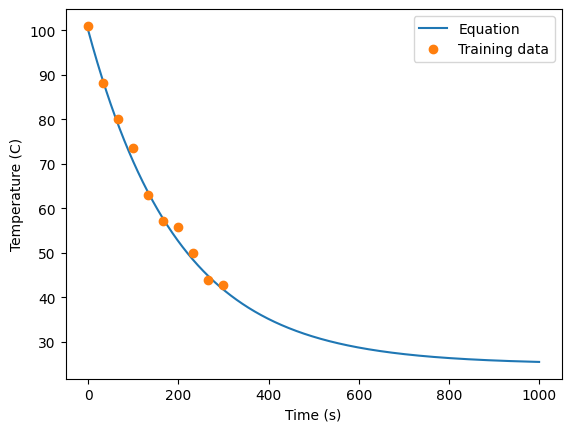

In [4]:
np.random.seed(42)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


In [5]:
model = Net(1,1, epochs=10000, lr=1e-4).to(DEVICE)

Epoch 0/10000, loss: 4627.05
Epoch 1000/10000, loss: 12.57
Epoch 2000/10000, loss: 3.34
Epoch 3000/10000, loss: 2.03
Epoch 4000/10000, loss: 1.38
Epoch 5000/10000, loss: 1.43
Epoch 6000/10000, loss: 1.30
Epoch 7000/10000, loss: 1.47
Epoch 8000/10000, loss: 1.39
Epoch 9000/10000, loss: 1.60


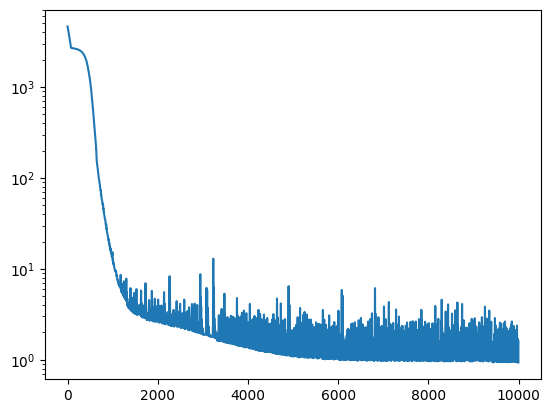

In [6]:
X = network.np_to_th(t)
y = network.np_to_th(T)

optimiser = optim.Adam(model.parameters(), lr=model.lr)
losses = []
for ep in range(model.epochs):
    optimiser.zero_grad()
    outputs = model.forward(X)
    loss = model.loss(y, outputs) + model.physics_loss()
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
    if ep % int(model.epochs / 10) == 0:
        print(f"Epoch {ep}/{model.epochs}, loss: {losses[-1]:.2f}")
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

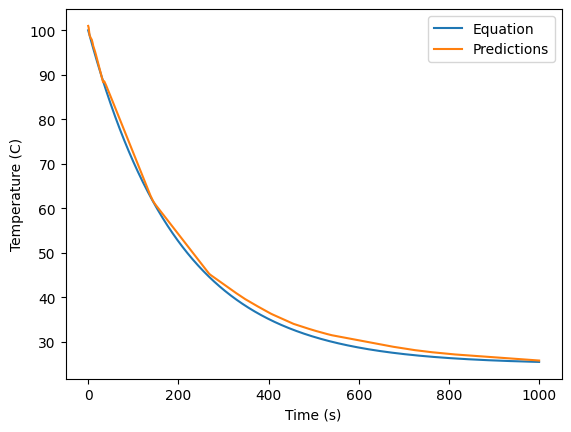

In [7]:
# Make testing data
t_te = np.linspace(0, 1000, 1000)
true = eq(t_te)
preds = model(network.np_to_th(t_te)).cpu().detach().numpy()

plt.plot(t_te, true)
plt.plot(t_te, preds)
plt.legend(['Equation', 'Predictions'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [9]:
model.r

Parameter containing:
tensor([0.0048], requires_grad=True)